In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import os
import glob
from PIL import Image

import shutil
import random

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers"

total_images = 0
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images =    len(glob.glob(os.path.join(class_path, "*.jpg"))) + \
                        len(glob.glob(os.path.join(class_path, "*.png"))) + \
                        len(glob.glob(os.path.join(class_path, "*.jpeg")))
        class_counts[class_name] = num_images
        total_images += num_images

print("Total Images Found:", total_images)
print("\nImages per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Total Images Found: 4317

Images per class:
daisy: 764 images
dandelion: 1052 images
rose: 784 images
sunflower: 733 images
tulip: 984 images


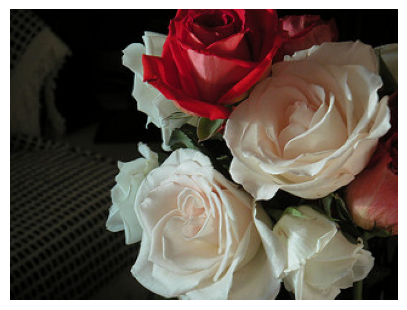

In [4]:
folder_name = os.path.join(dataset_path, "rose")

folder_images = glob.glob(os.path.join(folder_name, "*.jpg")) + \
                glob.glob(os.path.join(folder_name, "*.png")) + \
                glob.glob(os.path.join(folder_name, "*.jpeg"))

if folder_images:
    img = Image.open(folder_images[1])

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("No images found in the folder")

In [5]:
# Define paths
original_dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers"
output_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers_split"

# Define train/validation/test split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Check if the dataset is already split
if os.path.exists(output_path) and all(os.path.exists(os.path.join(output_path, split)) for split in ["train", "validation", "test"]):
    print("✅ Dataset is already split. Showing summary:\n")

    # Dictionary to store counts
    dataset_summary = {"train": {}, "validation": {}, "test": {}}
    
    for split in ["train", "validation", "test"]:
        print(f"📂 {split.upper()} SET:")
        for class_name in os.listdir(os.path.join(output_path, split)):
            class_path = os.path.join(output_path, split, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                dataset_summary[split][class_name] = num_images
                print(f"   - {class_name}: {num_images} images")
        print()

else:
    print("🔄 Splitting dataset into train, validation, and test sets...\n")

    # Create directories
    for split in ["train", "validation", "test"]:
        for class_name in os.listdir(original_dataset_path):
            os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

    # Split data
    for class_name in os.listdir(original_dataset_path):
        class_path = os.path.join(original_dataset_path, class_name)

        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)  # Shuffle before splitting

            train_split = int(train_ratio * len(images))
            val_split = int(val_ratio * len(images)) + train_split

            # Move files
            for i, image in enumerate(images):
                src_path = os.path.join(class_path, image)

                if i < train_split:
                    dst_path = os.path.join(output_path, "train", class_name, image)
                elif i < val_split:
                    dst_path = os.path.join(output_path, "validation", class_name, image)
                else:
                    dst_path = os.path.join(output_path, "test", class_name, image)

                shutil.copy(src_path, dst_path)

    print("✅ Dataset successfully split into train, validation, and test sets!")

✅ Dataset is already split. Showing summary:

📂 TRAIN SET:
   - daisy: 611 images
   - dandelion: 841 images
   - rose: 627 images
   - sunflower: 586 images
   - tulip: 787 images

📂 VALIDATION SET:
   - daisy: 76 images
   - dandelion: 105 images
   - rose: 78 images
   - sunflower: 73 images
   - tulip: 98 images

📂 TEST SET:
   - daisy: 77 images
   - dandelion: 106 images
   - rose: 79 images
   - sunflower: 74 images
   - tulip: 99 images



In [6]:
dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers_split"

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Não embaralhe para manter a ordem na avaliação
)

class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.
Class labels: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevents overfitting
    layers.Dense(len(class_labels), activation='softmax')  # Output layer
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

d:\Monte Carlo Digital\Projeto Flores e Vegetais\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

d:\Monte Carlo Digital\Projeto Flores e Vegetais\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 518ms/step - accuracy: 0.3549 - loss: 1.4427 - val_accuracy: 0.5233 - val_loss: 1.1046
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step - accuracy: 0.5252 - loss: 1.1595 - val_accuracy: 0.5651 - val_loss: 1.0310
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.5930 - loss: 1.0286 - val_accuracy: 0.6419 - val_loss: 0.9149
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.6255 - loss: 0.9297 - val_accuracy: 0.6488 - val_loss: 0.8432
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.6842 - loss: 0.8312 - val_accuracy: 0.7047 - val_loss: 0.7731
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 327ms/step - accuracy: 0.7400 - loss: 0.6860 - val_accuracy: 0.7233 - val_loss: 0.7477
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 325ms/step - accuracy: 0.7448 - loss: 0.6472 - val_accuracy: 0.7093 - val_loss: 0.7950
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.7828 - loss: 0

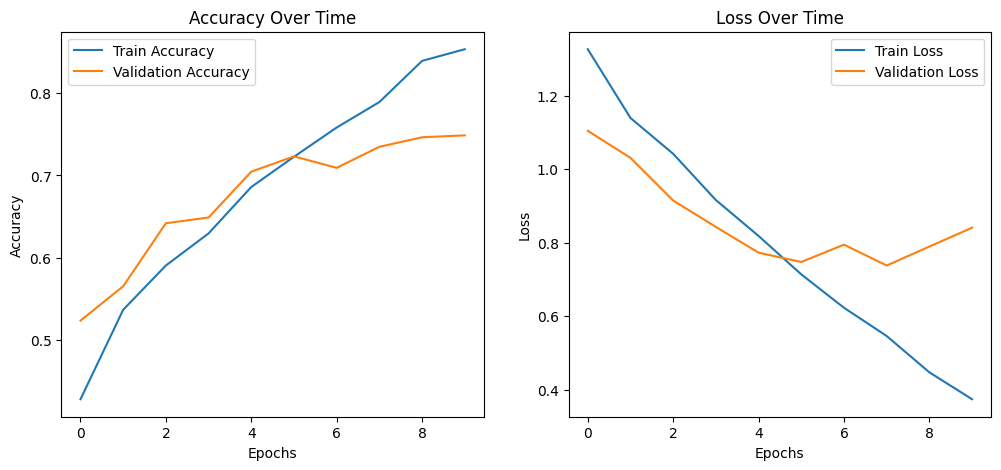

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.7277 - loss: 0.9738

Test Accuracy: 70.34%
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


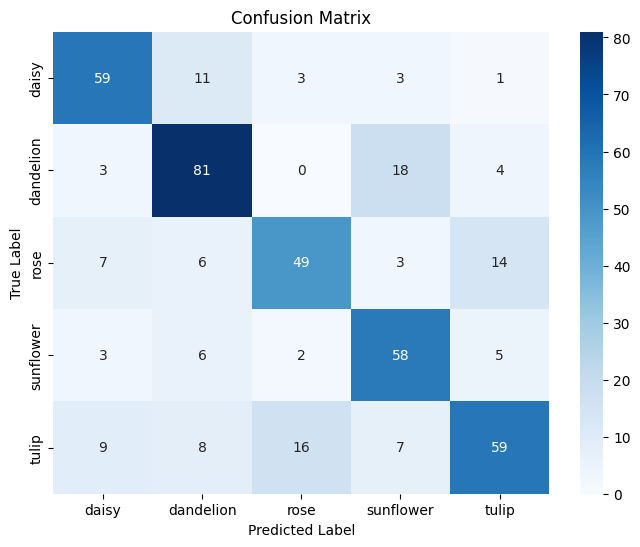


Classification Report:
               precision    recall  f1-score   support

       daisy       0.73      0.77      0.75        77
   dandelion       0.72      0.76      0.74       106
        rose       0.70      0.62      0.66        79
   sunflower       0.65      0.78      0.71        74
       tulip       0.71      0.60      0.65        99

    accuracy                           0.70       435
   macro avg       0.70      0.71      0.70       435
weighted avg       0.70      0.70      0.70       435



In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.show()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

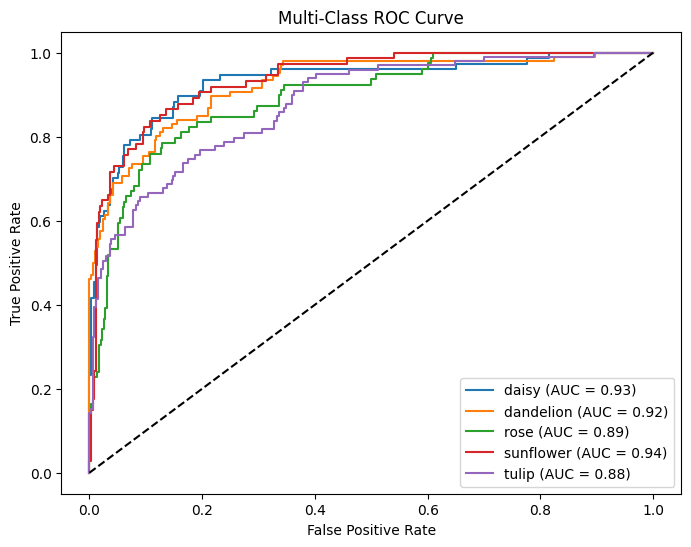

In [14]:
# ROC and AUC Analysis
# Convert true labels to one-hot encoding for multi-class ROC-AUC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Plot ROC Curve for Each Class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()